In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import MESS
import numpy as np
import pandas as pd

from collections import OrderedDict
from itertools import combinations
from scipy.stats import spearmanr

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate a small fake community dataset including pi, dxy, abund, & traits

In [137]:
def synthetic_community(model="random", nspecies=10):
    abunds = np.random.randint(1, 1000, nspecies)

    if model == "random":
        pis = np.random.random(nspecies)/10
        dxys = np.random.random(nspecies)/10
        trts = np.random.random(nspecies)*10
    elif model == "correlated":
        pis = abunds/1000.
        dxys = pis*1.15
        trts = abunds/10.
    elif model == "filtering":
        def filt(strength=10, victim_trait=-3.32923208, filt_opt=0):
            return 1 - (np.exp(-((victim_trait - filt_opt) ** 2)/strength))
        trts = 1-np.array([filt(strength=10, victim_trait=x/100, filt_opt=abunds.max()/100) for x in abunds])
        pis = np.random.random(nspecies)/10
        dxys = np.random.random(nspecies)/10
    elif model == "competition":
        trts = np.array([x - abunds.mean() for x in abunds])/10
        pis = np.random.random(nspecies)/10
        dxys = np.random.random(nspecies)/10
    dat = pd.DataFrame([], columns=["pi", "dxy", "abundance", "trait"])
    dat["pi"] = pis
    dat["dxy"] = dxys
    dat["abundance"] = abunds
    dat["trait"] = trts
    return dat
dat = synthetic_community("filtering")
display(dat)
print(dat["abundance"].mean(), dat["trait"].mean())

,pi,dxy,abundance,trait
0,0.038240,0.058679,51,0.006738
1,0.057584,0.002437,780,1.000000
2,0.051874,0.092990,138,0.018316
3,0.039852,0.033923,562,0.367879
4,0.006768,0.020443,252,0.049787
5,0.047357,0.037934,450,0.367879
6,0.057690,0.090130,646,0.367879
7,0.023873,0.010641,758,1.000000
8,0.079512,0.046297,506,0.367879
9,0.019435,0.012824,480,0.367879


(462.3, 0.3914237860112896)


## Correlations between datatypes


In [120]:
def calc_cors(in_df):
    diversity_df = in_df.copy()
    stat_dict = {}
    valid = set(["abundance", "pi", "dxy", "trait"])
    for pair in combinations(sorted(set(diversity_df.columns).intersection(valid)), r=2):
        diversity_df = in_df.copy()
        ## If doing traits then transform the trait values into distance from
        ## local trait mean. Should see positive correlation in filtering and
        ## negative in competition.
        if "trait" in pair:
            idx = pair.index("trait")
#            trt_mean = 
            diversity_df[pair[idx]] = np.abs(diversity_df[pair[idx]] - diversity_df["trait"].mean())
            display(diversity_df)
        
        cor = spearmanr(diversity_df[pair[0]], diversity_df[pair[1]])[0]
        if np.isnan(cor): cor = 0
        stat_dict["{}_{}_cor".format(pair[0], pair[1])] = cor
    return stat_dict
calc_cors(dat)

,pi,dxy,abundance,trait
0,0.028265,0.047283,22,6.38
1,0.016667,0.045493,49,1.18
2,0.063355,0.099414,66,15.82
3,0.045528,0.071626,26,10.38
4,0.093056,0.057664,30,14.38
5,0.038612,0.054977,1,14.62
6,0.053936,0.030766,3,12.62
7,0.001801,0.022427,37,13.18
8,0.000844,0.090548,66,15.82
9,0.054700,0.007340,29,13.38


,pi,dxy,abundance,trait
0,0.028265,0.047283,22,6.38
1,0.016667,0.045493,49,1.18
2,0.063355,0.099414,66,15.82
3,0.045528,0.071626,26,10.38
4,0.093056,0.057664,30,14.38
5,0.038612,0.054977,1,14.62
6,0.053936,0.030766,3,12.62
7,0.001801,0.022427,37,13.18
8,0.000844,0.090548,66,15.82
9,0.054700,0.007340,29,13.38


,pi,dxy,abundance,trait
0,0.028265,0.047283,22,6.38
1,0.016667,0.045493,49,1.18
2,0.063355,0.099414,66,15.82
3,0.045528,0.071626,26,10.38
4,0.093056,0.057664,30,14.38
5,0.038612,0.054977,1,14.62
6,0.053936,0.030766,3,12.62
7,0.001801,0.022427,37,13.18
8,0.000844,0.090548,66,15.82
9,0.054700,0.007340,29,13.38


{'abundance_dxy_cor': 0.36474332620803873,
 'abundance_pi_cor': -0.17629260766721874,
 'abundance_trait_cor': 0.3292682926829269,
 'dxy_pi_cor': 0.11515151515151514,
 'dxy_trait_cor': 0.498482545817653,
 'pi_trait_cor': 0.21276694028802262}

## Calculate generalized hill numbers for abundance and pi for the test data

In [11]:
np.array(np.ones(10))
for p in ["abundance", "pi"]:
    if p == "abundance":
        vals = None
    else:
        vals = dat[p]
    for i in range(0, 5):
        hval = MESS.stats.generalized_hill_number(abunds=dat["abundance"], vals=vals, order=i)
        print(p, i, hval)
for i in range(0, 5):
    hval = MESS.stats.trait_hill_number(abunds=dat["abundance"], traits=dat["trait"], order=i)
    print("trait", i, hval)
traits = pd.DataFrame([1.5])
MESS.stats.trait_hill_number(abunds=pd.DataFrame([100]), traits=traits)
from sklearn.metrics import pairwise_distances
traits = traits.values.reshape(-1, 1)
print(traits)
pairwise_distances(traits)

('abundance', 0, 0.02680965147453083)
('abundance', 1, 0.020523241887415097)
('abundance', 2, 0.01829597292392211)
('abundance', 3, 0.017270410886360606)
('abundance', 4, 0.016693114101585506)
('pi', 0, 0.022119496006088184)
('pi', 1, 0.01828988845523972)
('pi', 2, 0.01686920857774611)
('pi', 3, 0.01623919273621736)
('pi', 4, 0.01589464371780899)
('trait', 0, 10.965485946779129)
('trait', 1, 8.561483809888323)
('trait', 2, 7.507472667546)
('trait', 3, 6.945980372494117)
('trait', 4, 6.608012875040912)
[[1.5]]


array([[0.]])

## How do even vs uneven abundances interact with even and uneven pi distributions in the generalized hill framework?

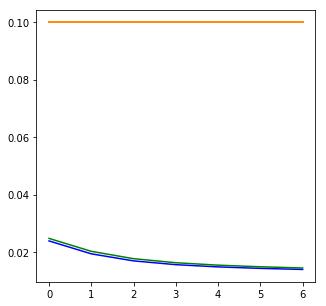

In [34]:
watdo = MESS.stats.generalized_hill_number
fig, ax = plt.subplots(figsize=(5, 5))
xs = list(range(0,7))

## Rand abund even pi
abunds = dat["abundance"]
even_pi = np.array([0.04] * 10)
ys = [watdo(abunds, even_pi, i) for i in xs]
ax.plot(xs, ys, c='b')

## Even abund even pi
abunds = np.array([10] * 10)
even_pi = np.array([0.04] * 10)
ys = [watdo(abunds, even_pi, i) for i in xs]
ax.plot(xs, ys, c='r')
#vals = np.ones(len(dat["abundance"]))

## Rand abund rand pi
abunds = dat["abundance"]
vals = dat["pi"]
ys = [watdo(abunds, vals, i) for i in xs]
ax.plot(xs, ys, c='g')

## even abund rand pi
abunds = np.array([10] * 10)
vals = dat["pi"]
ys = [watdo(abunds, vals, i) for i in xs]
ax.plot(xs, ys, c='orange')


## Formulate hill # for traits

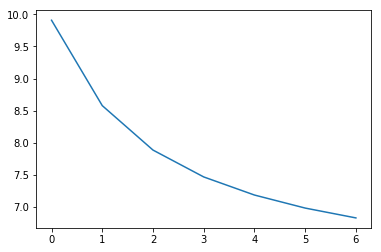

In [4]:
xs = list(range(0,7))
ys = [MESS.stats.trait_hill_number(abunds=dat["abundance"], traits=dat["trait"], order=i) for i in xs]
plt.plot(xs, ys)

In [5]:
MESS.stats.calculate_sumstats(dat, verbose=True)
#MESS.stats.trait_hill_number(dat["abundance"], dat["trait"], order=2)

,S,abund_h1,abund_h2,abund_h3,abund_h4,pi_h1,pi_h2,pi_h3,pi_h4,mean_pi,std_pi,skewness_pi,kurtosis_pi,median_pi,iqr_pi,mean_dxys,std_dxys,skewness_dxys,kurtosis_dxys,median_dxys,iqr_dxys,trees,trait_h1,trait_h2,trait_h3,trait_h4,mean_local_traits,std_local_traits,skewness_local_traits,kurtosis_local_traits,median_local_traits,iqr_local_traits,abundance_dxy_cor,abundance_pi_cor,abundance_trait_cor,dxy_pi_cor,dxy_trait_cor,pi_trait_cor,SGD_0_0,SGD_0_1,SGD_0_2,SGD_0_3,SGD_0_4,SGD_0_5,SGD_0_6,SGD_0_7,SGD_0_8,SGD_0_9,SGD_1_0,SGD_1_1,SGD_1_2,SGD_1_3,SGD_1_4,SGD_1_5,SGD_1_6,SGD_1_7,SGD_1_8,SGD_1_9,SGD_2_0,SGD_2_1,SGD_2_2,SGD_2_3,SGD_2_4,SGD_2_5,SGD_2_6,SGD_2_7,SGD_2_8,SGD_2_9,SGD_3_0,SGD_3_1,SGD_3_2,SGD_3_3,SGD_3_4,SGD_3_5,SGD_3_6,SGD_3_7,SGD_3_8,SGD_3_9,SGD_4_0,SGD_4_1,SGD_4_2,SGD_4_3,SGD_4_4,SGD_4_5,SGD_4_6,SGD_4_7,SGD_4_8,SGD_4_9,SGD_5_0,SGD_5_1,SGD_5_2,SGD_5_3,SGD_5_4,SGD_5_5,SGD_5_6,SGD_5_7,SGD_5_8,SGD_5_9,SGD_6_0,SGD_6_1,SGD_6_2,SGD_6_3,SGD_6_4,SGD_6_5,SGD_6_6,SGD_6_7,SGD_6_8,SGD_6_9,SGD_7_0,SGD_7_1,SGD_7_2,SGD_7_3,SGD_7_4,SGD_7_5,SGD_7_6,SGD_7_7,SGD_7_8,SGD_7_9,SGD_8_0,SGD_8_1,SGD_8_2,SGD_8_3,SGD_8_4,SGD_8_5,SGD_8_6,SGD_8_7,SGD_8_8,SGD_8_9,SGD_9_0,SGD_9_1,SGD_9_2,SGD_9_3,SGD_9_4,SGD_9_5,SGD_9_6,SGD_9_7,SGD_9_8,SGD_9_9
0,10,8.577908,7.824862,7.354675,7.023941,9.04425,8.408298,7.943665,7.577883,0.052044,0.022644,0.204419,-0.352321,0.052656,0.018476,0.035742,0.033694,0.429288,-1.688847,0.014083,0.062423,0,8.578353,7.886023,7.467422,7.185557,5.112537,2.572397,-0.526627,-1.428194,6.548648,4.419491,-0.090909,0.212121,0.29697,0.357576,-0.466667,0.515152,1,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


## Trash below here

In [75]:
df = pd.read_csv("/home/isaac/Continuosity/MESS/analysis/figure3-sims/badsims.txt", sep="\t", header=0)
np.abs([-1, 1])

array([1, 1])

# Weevil data

,S,abund_h1,abund_h2,abund_h3,abund_h4,pi_h1,pi_h2,pi_h3,pi_h4,mean_pi,std_pi,skewness_pi,kurtosis_pi,median_pi,iqr_pi,trees,SGD_0,SGD_1,SGD_2,SGD_3,SGD_4,SGD_5,SGD_6,SGD_7,SGD_8,SGD_9
0,26,15.551964,11.553471,9.749593,8.776689,16.525113,13.293617,11.35714,10.189882,0.022862,0.022351,1.469762,1.797334,0.020936,0.019995,0,10,2,6,4,1,0,1,0,1,1


,S,abund_h1,abund_h2,abund_h3,abund_h4,pi_h1,pi_h2,pi_h3,pi_h4,mean_pi,std_pi,skewness_pi,kurtosis_pi,median_pi,iqr_pi,trees,SGD_0,SGD_1,SGD_2,SGD_3,SGD_4,SGD_5,SGD_6,SGD_7,SGD_8,SGD_9
0,27,12.342967,8.390983,7.234338,6.756258,17.708787,14.927681,13.310007,12.280974,0.025299,0.022751,0.947168,0.086781,0.019174,0.028364,0,7,4,3,3,4,2,1,0,0,3


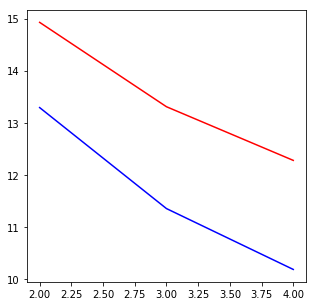

In [32]:
m_df = pd.read_csv("/home/isaac/SGD_empirical/empirical_weevils/mauritius.dat", header=0)
r_df = pd.read_csv("/home/isaac/SGD_empirical/empirical_weevils/reunion.dat", header=0)
m_ss = MESS.stats.calculate_sumstats(m_df)
r_ss = MESS.stats.calculate_sumstats(r_df)

display(m_ss)
display(r_ss)

fig, ax = plt.subplots(figsize=(5, 5))
xs = range(2, 5)
ys = [m_ss["pi_h{}".format(i)] for i in xs]
ax.plot(xs, ys, c='b')
ys = [r_ss["pi_h{}".format(i)] for i in xs]
ax.plot(xs, ys, c='r')

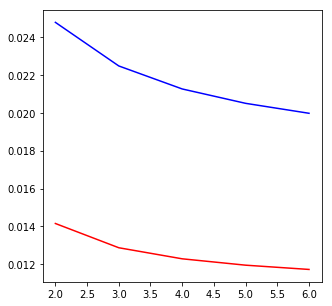

In [35]:
watdo(m_df["abundance"], m_df["pi"])/len(m_df)
fig, ax = plt.subplots(figsize=(5, 5))
xs = range(2, 7)
ys = [watdo(m_df["abundance"], m_df["pi"], i) for i in xs]
ax.plot(xs, ys, c='b')
ys = [watdo(r_df["abundance"], r_df["pi"], i) for i in xs]
ax.plot(xs, ys, c='r')

In [74]:
print(len(m_df), spearmanr(m_df["abundance"], m_df["pi"]))
print(len(r_df), spearmanr(r_df["abundance"], r_df["pi"]))
res = spearmanr([2] * 26, m_df["abundance"])[0]
np.isnan(res)

(26, SpearmanrResult(correlation=0.5036941254918288, pvalue=0.008706277317942965))
(27, SpearmanrResult(correlation=0.6380779590471193, pvalue=0.000342443669086618))


True

# Random MESS janks

(array([ 5.,  2.,  6.,  3.,  2.,  9., 11.,  9.,  6.,  4.,  5.,  7.,  4.,
         3.,  4.,  3.,  6.,  7.,  2.,  2.]),
 array([0.0001   , 0.0001445, 0.000189 , 0.0002335, 0.000278 , 0.0003225,
        0.000367 , 0.0004115, 0.000456 , 0.0005005, 0.000545 , 0.0005895,
        0.000634 , 0.0006785, 0.000723 , 0.0007675, 0.000812 , 0.0008565,
        0.000901 , 0.0009455, 0.00099  ]),
 <a list of 20 Patch objects>)

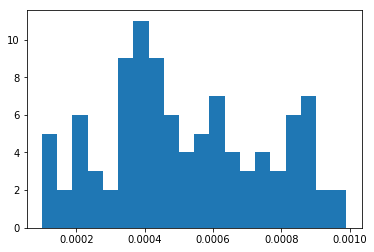

In [94]:
r = MESS.Region("watdo-tmp")
## Region params
r.set_param("project_dir", "/tmp")
r.set_param("generations", 0)
r.set_param("community_assembly_model", "neutral")
r.set_param("mutation_rate", 2.2e-8)
r.set_param("S_m", (500, 5000))
r.set_param("J", (1000, 2000))
r.set_param("m", (0.001, 0.01))
r.set_param("speciation_prob", (0.0001, 0.001))
plt.hist(MESS.util.sample_param_range(r.islands["Loc1"]._priors["speciation_prob"], nsamps=100), bins=20)

In [15]:
r = MESS.Region("watdo-tmp")
## Region params
r.set_param("project_dir", "/tmp")
r.set_param("generations", 0)
r.set_param("community_assembly_model", "neutral")
r.set_param("mutation_rate", 2.2e-8)
r.set_param("S_m", (500, 5000))
r.set_param("J", (1000, 2000))
r.set_param("m", (0.001, 0.01))
r.set_param("speciation_prob", (0.0001, 0.001))
r.run(sims=1)

    Generating 1 simulation(s).
  [####################] 100%  Finished 0 simulations    | 0:00:00 | 
 

(1032, 647, 693)


(array([  2.,   7.,   6.,  11.,  21.,  47.,  53.,  64.,  78.,  85., 120.,
         79.,  61.,  29.,   9.,  15.,   0.,   0.,   3.,   3.]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
         0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 20 Patch objects>)

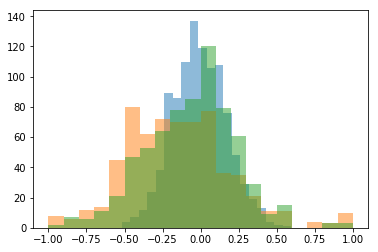

In [164]:
import pandas as pd
stat = "abundance_trait_cor"
df = pd.read_csv("/home/iovercast/Continuosity/MESS/MESS/default_MESS/SIMOUT.txt", sep="\t", header=0)
df = df[df["_lambda"] > 0]
ndf = df[df["community_assembly_model"] == "neutral"]
fdf = df[df["community_assembly_model"] == "filtering"]
cdf = df[df["community_assembly_model"] == "competition"]
print(len(ndf), len(fdf), len(cdf))
plt.hist(ndf[stat], bins=20, alpha=.5)
plt.hist(fdf[stat], bins=20, alpha=.5)
plt.hist(cdf[stat], bins=20, alpha=.5)

In [161]:
MESS.Metacommunity()